#Infection Project - Khan Academy

In [1]:
from py2neo import Node, Relationship, Path, Rev
from py2neo import authenticate, Graph
from itertools import *
import requests
import numpy as np
import unicodedata
import numpy as np
import time
import datetime
import random
import names
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

In [2]:
%load_ext cypher
authenticate("localhost:7474", "neo4j", "neo4j")
graph = Graph("http://localhost:7474/db/data/")
cypher = graph.cypher

## User Class

In [3]:
class User:
    
    """
    Creates a User
    User has attributes Name, Version and Last Login
    When user is creates, a database node is created in Neo4j
    When user is infected, the node is remove and replaced by new node (version update)
    """
    
    # Initializer
    def __init__(self):
        
        # Give user a full name. Generated randomly
        self.name =  unicodedata.normalize('NFKD', names.get_full_name()).encode('ascii','ignore')
        
        # Current base version of the website
        self.khanAcademyVersion = 'A'
        
        # keep all students in a set
        self.students = set()
        
        # keep all coaches in a set
        self.coaches = set()
        
        # Number of loggins, int days ago
        self.lastLogin = random.randint(0,50)
        
        ######################DATABASE#######################
        
        # Save this user as a node in the graph database
        self.databaseNode = Node("UserA", name = self.name, khanAcademyVersion = self.khanAcademyVersion, LastLogin = self.lastLogin)
        graph.create(self.databaseNode)
        
        
        
    def isCoaching(self, student):
        
        if (student != self and (student not in self.students or self not in student.coaches)):
            self.students |= {student}
            student.coaches |= {self}
        
        ######################DATABASE#######################
            graph.create(Relationship(self.databaseNode, "IS_COACHING", student.databaseNode))
        
    
    def isStudent(self, coach):
        
        if (coach != self and (self not in coach.students or coach not in self.coaches)):
            coach.students |= {self}
            self.coaches |= {coach}
        
        ######################DATABASE#######################
            graph.create(Relationship(coach.databaseNode, "IS_COACHING", self.databaseNode))
    
    #Class method for user infection    
    def infect(self):
        
        # Deploys new version of Khan Academy to this user
        self.khanAcademyVersion = 'B'
        
        ######################DATABASE#######################
        
        # save all relationships, ingoing and outgoing of this node
        incomingRel = self.databaseNode.match_incoming(rel_type="IS_COACHING")
        outgoingRel = self.databaseNode.match_outgoing(rel_type="IS_COACHING")
        
        # create a node that is of typer UserN
        self.databaseNode = Node("UserB", name = self.name, khanAcademyVersion = self.khanAcademyVersion, LastLogin = self.lastLogin)
        graph.create(self.databaseNode)     
        
        # Build the same relationships as the UserA node
        for r in incomingRel:
            startNode = r.start_node
            graph.create(Relationship(startNode, "IS_COACHING", self.databaseNode))
        for r in outgoingRel:
            endNode = r.end_node
            graph.create(Relationship(self.databaseNode, "IS_COACHING", endNode))
        
        
        # Delete the old node
        cypher.execute("MATCH (u :UserA {khanAcademyVersion: {khanAcademyVersion}, name: {name}})-[r]-() DELETE r", khanAcademyVersion = 'A', name = self.name)
        cypher.execute("MATCH n WHERE (n.khanAcademyVersion = {khanAcademyVersion} AND n.name = {name}) DELETE n", khanAcademyVersion = 'A', name = self.name)
        

#Generate Users + Pseudo-Random Relationships

In [22]:
# Lets make some fake data to play around with!

def generateUsers(numberOfUsers):
    """
    Create n fake users (n = argument numer) and gives them some pseudo random relationships.
    then remove the users that have no relationships. This is so that we can test the failure
    of the limited infection method.
    """
    AllUsers = []
    Users = []

    # make 200 users and place them in an array
    for i in range(0,numberOfUsers):
        newUser = User()
        Users.append(newUser)
        
    AllUsers.extend(Users)
    # create relationships between relationship-less nodes remaining in the database
    def createRelationships(Users):
        i = 1
        for u in Users:
            i = i+1
            if (i%15 == 0):
                potentialRels = map(lambda x: random.randint(-8,8), np.zeros(random.randint(0,10)))
                set(potentialRels)
                for num in potentialRels:
                    u.isCoaching(Users[(i+num)%len(Users)])
                    #graph.create(Relationship(u.databaseNode, "IS_COACHING", Users[(i+num)%len(Users)].databaseNode))


    # until we have only a few remaining nodes without relationships
    while (len(Users) > 20):
        remaining = []

        createRelationships(Users)

        for u in Users:
            for j in u.databaseNode.match_incoming(rel_type=None, start_node=None, limit=None):
                if (len(j) != 0):
                    remaining.append(u)
        Users = list(set(Users) - set(remaining))
        
    # this cypher instruction deletes all nodes that have no relationships.
    # we could keep them, but it's better to test features on users that have relationships
    cypher.execute("MATCH (n) WHERE size((n)--())=0 DELETE (n)")

    visualizeNXGraph()
    
    return AllUsers

#Visualize NetworkX Graph

In [21]:
def visualizeNXGraph():
    
    results = %cypher MATCH (u)-[r:IS_COACHING]-(n) RETURN u.name, r, n.name

    # get information from the database on visualize it with NetworkX
    
    g = results.get_graph()
    node_map = {'UserA':'green', 'UserB':'red'}
    plt.figure(figsize=(20,10))
    nx.draw(g,pos=nx.shell_layout(g), node_color=[node_map[g.node[node]['labels'][0]] for node in g])

#Limited Infection

In [40]:
def partial_infection(usersToInfect):
    
    # get all subgraph in a dictionary
    subgraphs = grabSubgraphs()
    # place them in a list for computation
    list(subgraphs.values())

    # get all the possible combinations that can result in the value passing in the argument 'usersToInfect'
    c = chain(*[combinations(list(subgraphs.values()), i) for i in range(len(list(subgraphs.values()))+1)])
    combinationToInfect = [n for n in c if sum(n) == usersToInfect]

    # crawl through and infect the selected subgraphs
    if (len(combinationToInfect) > 0):
        for name, val in subgraphs.items():
            if val in combinationToInfect[0]:
                for user in AllUsers:
                    if user.name == name:
                        crawl(user)
    # tell user if it is not possible to infect exact amount of users
    else:
        print "Not possible to infect exaclty", usersToInfect, "users. Please chose any combination of", list(subgraphs.values())
    
    visualizeNXGraph()
    
    
    
def grabSubgraphs():
    """
    Get all the subgraph size and the name of any node in that subgraph. place into dictionary
    """
    # grab all nodes directly from the database. Only nodes that are in previous version
    nodes = %cypher MATCH n WHERE n.khanAcademyVersion = "B" RETURN n

    # put nodes into a dafaframe and initialize containers for results
    nodes = nodes.dataframe
    allnodes=[]
    subgraphChunks = {}
    
    # put the rows from the dataframe into a list
    for index, row in nodes.iterrows():
        allnodes.append(row[0])
            
    # grab a name associated with a subgraph and and the quantity of nodes in that subgraph
    while(len(allnodes) > 0):
        name = unicodedata.normalize('NFKD', allnodes[0]['name']).encode('ascii','ignore')
        subgraph = %cypher MATCH p=(n { name: {name}})-[r*0..]-(m) WITH NODES(p) AS nodes UNWIND nodes AS node RETURN DISTINCT node
        subgraph = subgraph.dataframe
        subarray = []
        for index, row in subgraph.iterrows():
            subarray.append(row[0])
        allnodes = filter(lambda x:x not in subarray, allnodes)
        subgraphChunks[name] = len(subarray)
    return subgraphChunks


def crawl(user):
    """
    Recursively infect everyone with a coach or student relationship
    """
    iuser = user
    iuser.infect()
    for u in user.coaches:
        if u.khanAcademyVersion == 'A':
            crawl(u)
    for u in user.students:
        if u.khanAcademyVersion == 'A':
            crawl(u)

#Total Infection

In [25]:
def total_infection():
    """
    Infect all users that are not yet infected
    This can be done much faster with a simple Cypher instruction, but would not have the effect
    of re-creating the nodes as a UserB node in the graph database.
    """
    for user in AllUsers:
        if (user.khanAcademyVersion == 'A'):
            user.infect()
            
    visualizeNXGraph()

272 rows affected.


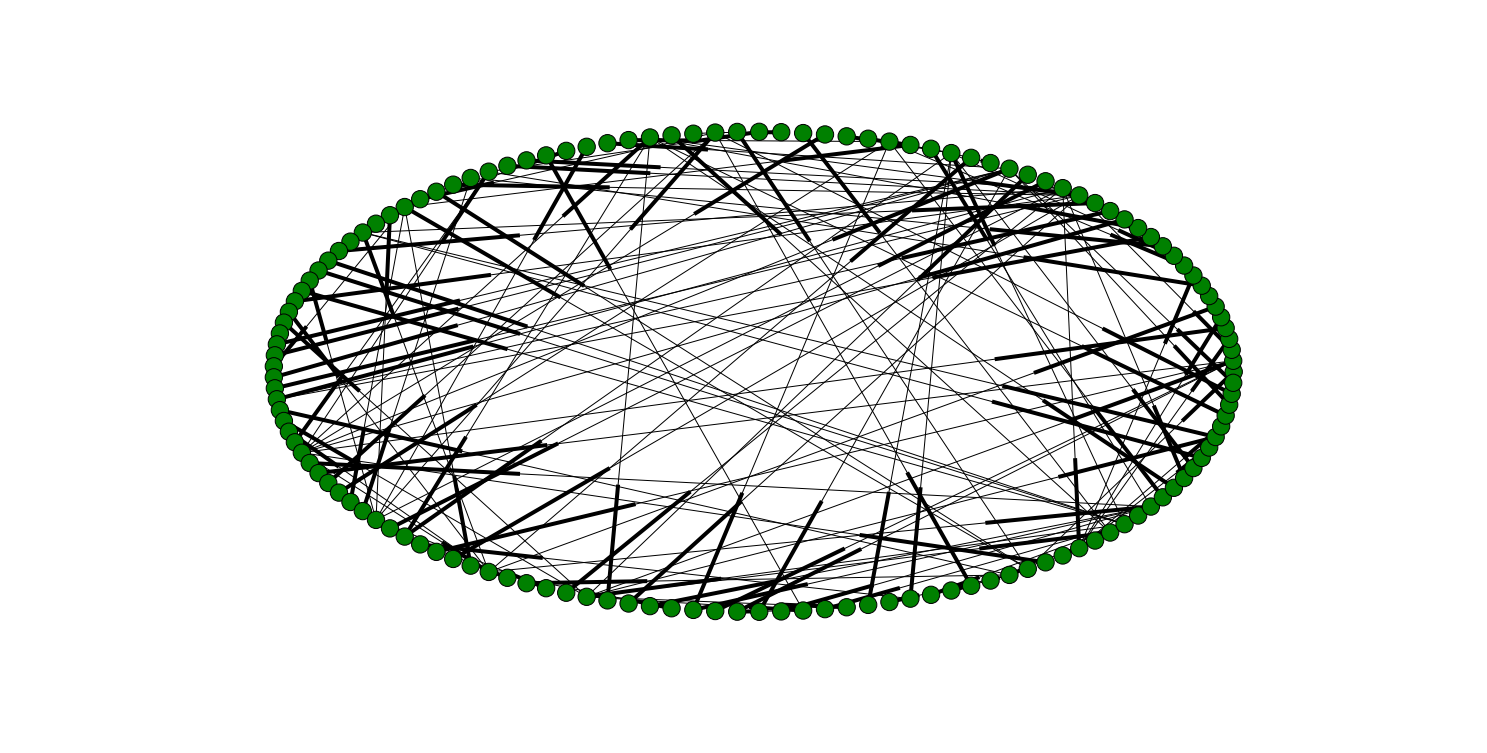

In [31]:
AllUsers = generateUsers(150)

137 rows affected.
105 rows affected.
3 rows affected.
17 rows affected.
12 rows affected.
Not possible to infect exaclty 500 users. Please chose any permutation of [3, 17, 12, 105]
272 rows affected.


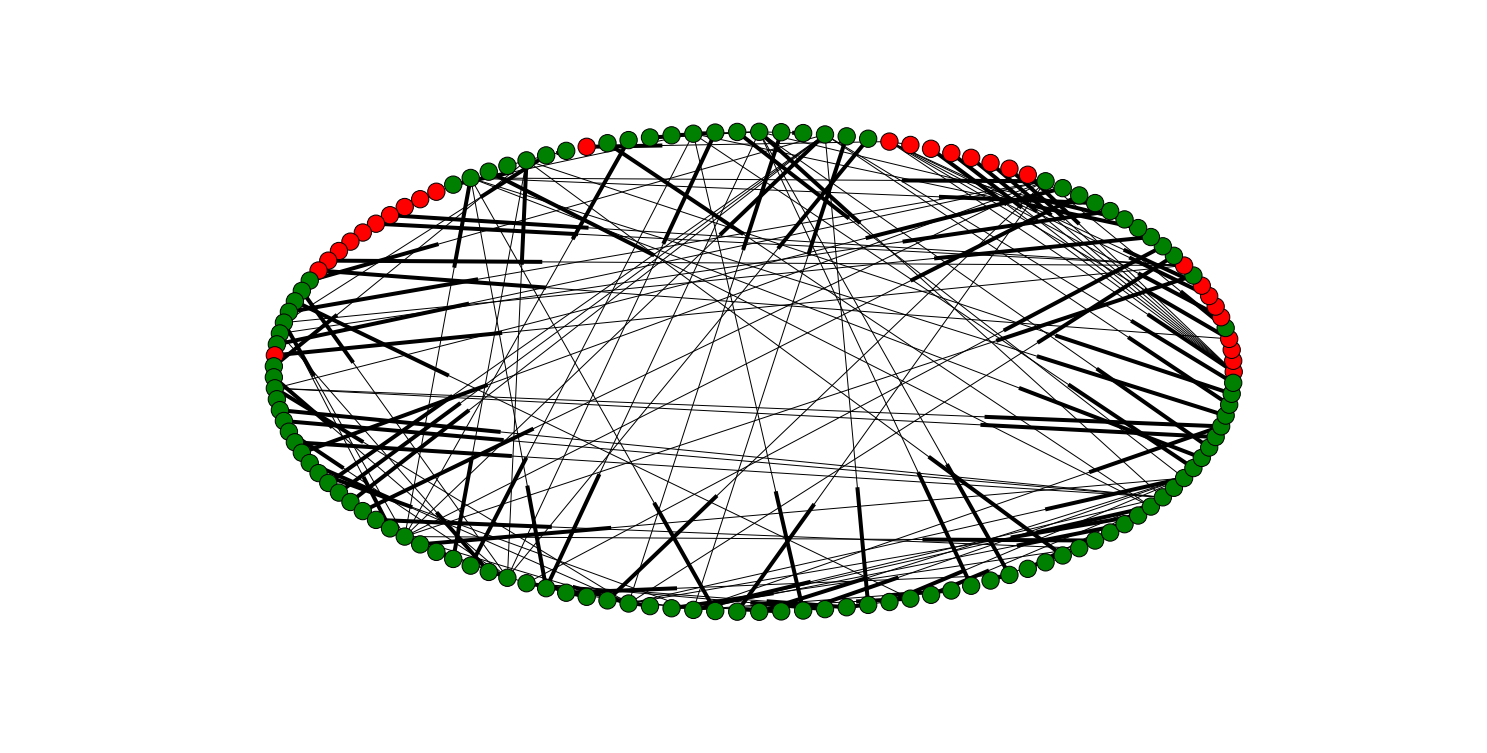

In [33]:
partial_infection(500)

272 rows affected.


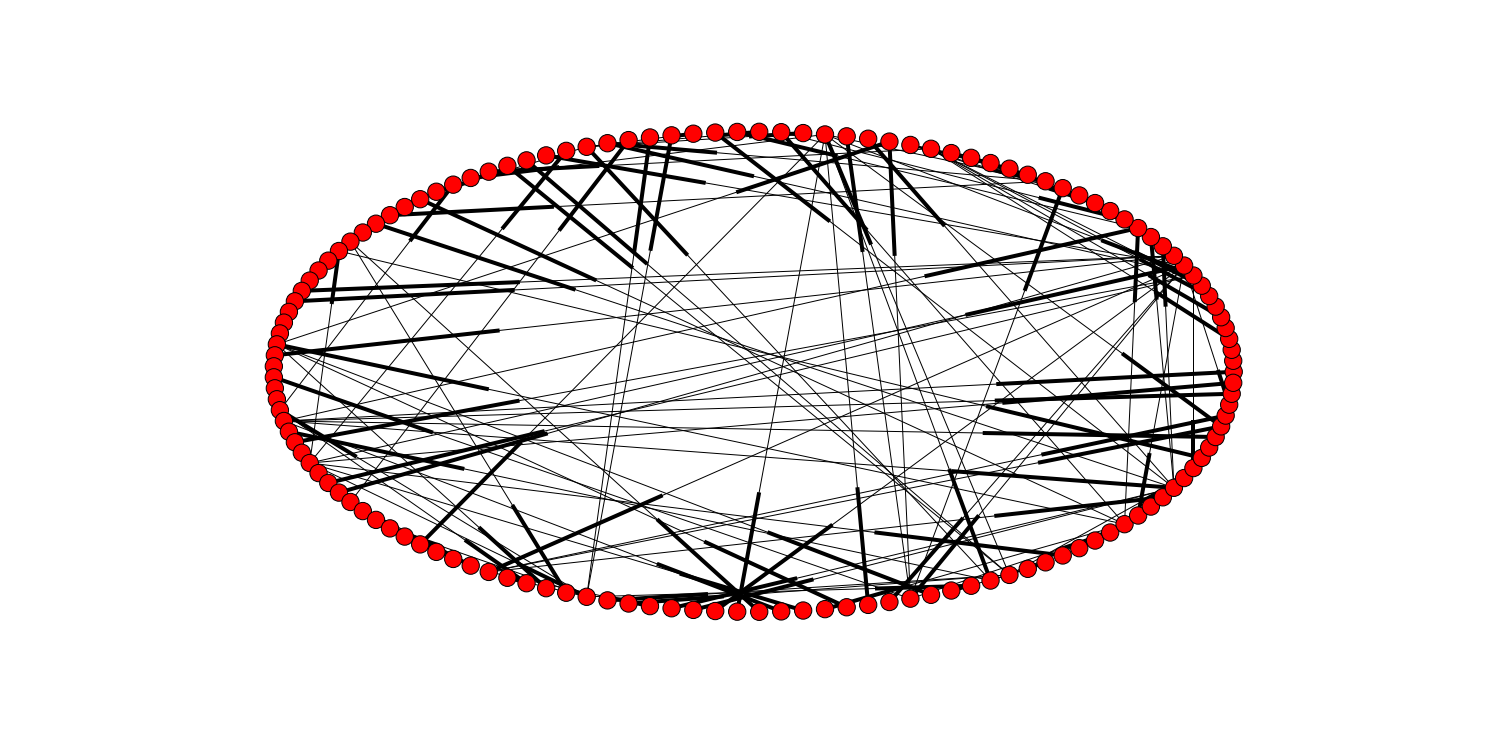

In [36]:
total_infection()